A simple frequency-based pairing heap:

In [1]:
:ext BangPatterns

import Data.Semigroup     (Semigroup(..))
import Data.List.NonEmpty (NonEmpty(..))
import Data.Foldable      (Foldable(..))

data Heap a =
    Heap {-# UNPACK #-} !Int
         !a
         (HeapList a)

infixr 5 :-
data HeapList a
    = Nil
    | (:-) {-# UNPACK #-} !(Heap a)
           (HeapList a)

instance Foldable Heap where
    foldr f b (Heap _ x xs) = f x (foldr f b xs)

    foldl' f !b (Heap _ x xs) =
        case f b x of
            !b' -> foldl' f b' xs

instance Foldable HeapList where
    foldr _ b Nil                 = b
    foldr f b (Heap _ x xs :- ys) = f x (foldr f (foldr f b ys) xs)

    foldl' _ !b Nil = b
    foldl' f !b (Heap _ x xs :- ys) =
        case f b x of
            !b' -> case foldl' f b' xs of
              !b'' -> foldl' f b'' ys

instance Semigroup (Heap a) where
    (Heap i x xs) <> (Heap j y ys)
      | i <= j = Heap i x (Heap j y ys :- xs)
      | otherwise = Heap j y (Heap i x xs :- ys)
    sconcat (ys :| [])        = ys
    sconcat (ys :| [zs])      = ys <> zs
    sconcat (ys :| (z:zz:zs)) = (ys <> z) <> sconcat (zz :| zs)

mergeHeaps :: Heap a -> HeapList a -> Heap a
mergeHeaps t Nil               = t
mergeHeaps t1 (t2 :- Nil)      = t1 <> t2
mergeHeaps t1 (t2 :- t3 :- ts) = (t1 <> t2) <> mergeHeaps t3 ts

singleton :: Int -> a -> Heap a
singleton i x = Heap i x Nil

insert :: Int -> a -> Heap a -> Heap a
insert !i !x (Heap j y ys)
  | i <= j = Heap i x (Heap j y ys :- Nil)
  | otherwise = Heap j y (Heap i x Nil :- ys)

insertList :: Int -> a -> HeapList a -> Heap a
insertList !i !x Nil = Heap i x Nil
insertList !i !x (y :- ys) = insert i x (mergeHeaps y ys)

fromList :: [(Int,a)] -> Heap a
fromList [] = error "fromList: Empty list"
fromList (x:xs) = sconcat (fmap (uncurry singleton) (x :| xs))

minView :: Heap a -> (Int, a, Maybe (Heap a))
minView (Heap i x xs) = (i, x, case xs of
  Nil -> Nothing
  y :- ys -> Just (mergeHeaps y ys))

A function to count the frequencies of some elements:

In [2]:
import           Data.Map.Strict (Map)
import qualified Data.Map.Strict as Map

newtype Frequencies a
    = Frequencies
    { getFrequencies :: Map a Int
    }

frequencies :: (Ord a, Foldable f) => f a -> Frequencies a
frequencies = Frequencies . foldl' (\m x -> Map.insertWith (+) x 1 m) Map.empty

And a way to show frequencies

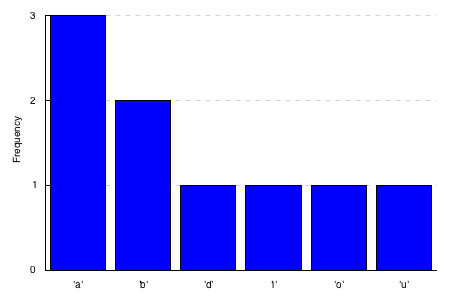

In [3]:
import Graphics.Rendering.Chart (layout_x_axis,laxis_generate,layout_y_axis
                                ,toRenderable,autoIndexAxis,laxis_title,layout_plots
                                ,plotBars,plot_bars_values,addIndexes)
import Data.Default.Class       (def)
import Control.Lens             ((.~))
import IHaskell.Display         (IHaskellDisplay(display))

instance Show a => IHaskellDisplay (Frequencies a) where
    display (Frequencies values)
        = display
        $ toRenderable
        $ layout_x_axis . laxis_generate .~ autoIndexAxis (map show (Map.keys values))
        $ layout_y_axis . laxis_title .~ "Frequency"
        $ layout_plots .~ [ plotBars
                          $ plot_bars_values .~ addIndexes (map pure (Map.elems values))
                          $ def ]
        $ def

:opt svg

frequencies "aaabioubd"

A Huffman tree:

In [4]:
data Tree a
    = Leaf {-# UNPACK #-} !Int a
    | Node {-# UNPACK #-} !Int (Tree a) (Tree a)

And a way to display that

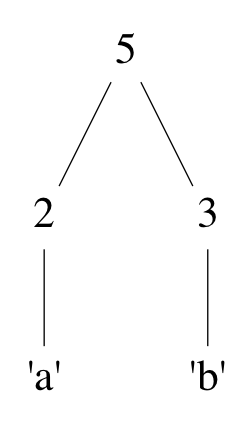

In [6]:
:ext FlexibleContexts

import           Diagrams.TwoD.Layout.Tree (renderTree,symmLayout)
import           Diagrams.Prelude          (text,fontSizeL,circle,fc
                                           ,lc,white,pad,centerXY,(#)
                                           ,(~~))
import           IHaskell.Display          (IHaskellDisplay(display))
import qualified Data.Tree                 as Tree

instance Show a => IHaskellDisplay (Tree a) where
    display = display . diagram . fblEx . toTree
      where
        toTree (Leaf i x) = Tree.Node (show i) [Tree.Node (show x) []]
        toTree (Node i l r) = Tree.Node (show i) [toTree l, toTree r]
        fblEx t' =
            renderTree 
                (\n -> text n # fontSizeL 0.2 <> circle 0.2 # fc white # lc white)
                (~~)
                (symmLayout t') # centerXY # pad 1.1
    
Node 5 (Leaf 2 'a') (Leaf 3 'b')

Building a tree is then easy:

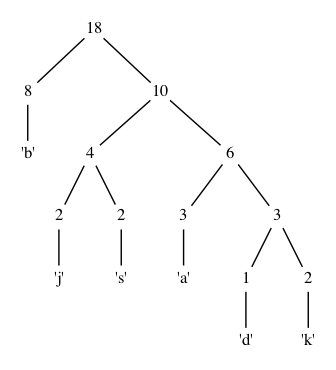

In [7]:
huffmanTree :: Ord a => [a] -> Tree a
huffmanTree xs = go heap
  where
    Frequencies freqs = frequencies xs
    heap = fromList [ (i, Leaf i v) | (v,i) <- Map.toList freqs ]
    go hp = case minView hp of
      (_,x,Nothing) -> x
      (i,x,Just xs) -> case minView xs of
        (j,y,Nothing) -> Node (i+j) x y
        (j,y,Just ys) -> go (insert (i+j) (Node (i+j) x y) ys)

huffmanTree "abkjbdkjbabsbsbbab"